In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import seaborn as sns

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/titanic/train.csv
/kaggle/input/titanic/test.csv
/kaggle/input/titanic/gender_submission.csv


In [2]:
train = pd.read_csv('/kaggle/input/titanic/train.csv')
test = pd.read_csv('/kaggle/input/titanic/test.csv')

In [3]:
train.head(5)

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S


In [4]:
train.isnull().sum()

PassengerId      0
Survived         0
Pclass           0
Name             0
Sex              0
Age            177
SibSp            0
Parch            0
Ticket           0
Fare             0
Cabin          687
Embarked         2
dtype: int64

In [5]:
Dataset = [train,test]

## Extract the Title for the dataset

In [6]:
for dataset in Dataset:
    dataset['Title'] = dataset['Name'].str.extract(' ([A-Za-z]+)\.', expand=False)
train['Title'].value_counts()

Mr          517
Miss        182
Mrs         125
Master       40
Dr            7
Rev           6
Mlle          2
Major         2
Col           2
Countess      1
Capt          1
Ms            1
Sir           1
Lady          1
Mme           1
Don           1
Jonkheer      1
Name: Title, dtype: int64

In [7]:
test['Title'].value_counts()

Mr        240
Miss       78
Mrs        72
Master     21
Col         2
Rev         2
Ms          1
Dr          1
Dona        1
Name: Title, dtype: int64

In [8]:
def replace_titles(x):
    title=x['Title']
    if title in ['Countess','Rev','Major','Sir','Lady']:
        return 'Master'
    if title in ['Col','Capt',]:
        return 'Mr'
    elif title in ['Mme']:
        return 'Mrs'
    elif title in ['Mlle', 'Ms']:
        return 'Miss'
    elif title in ['Dr','Don','Jonkheer','Dona']:
        if x['Sex']=='Male':
            return 'Mr'
        else:
            return 'Mrs'
    else:
        return title
    
train['Title']=train.apply(replace_titles, axis=1)
test['Title']=test.apply(replace_titles, axis=1)

In [9]:
train['Title'].value_counts()

Mr        520
Miss      185
Mrs       135
Master     51
Name: Title, dtype: int64

<AxesSubplot:xlabel='Title', ylabel='Survived'>

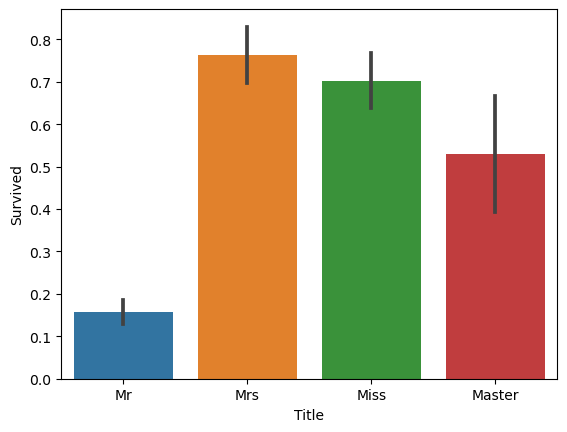

In [10]:
sns.barplot(x='Title',y='Survived',data = train)

In [11]:
train["Age"].fillna(train.groupby("Title")["Age"].transform("mean"), inplace=True)
test["Age"].fillna(test.groupby("Title")["Age"].transform("mean"), inplace=True)
train.isnull().sum()

PassengerId      0
Survived         0
Pclass           0
Name             0
Sex              0
Age              0
SibSp            0
Parch            0
Ticket           0
Fare             0
Cabin          687
Embarked         2
Title            0
dtype: int64

## Relatives and Fare

In [12]:
for dataset in Dataset:
    dataset['relatives'] = dataset['SibSp'] + dataset['Parch']
    del dataset['SibSp']
    del dataset['Parch']

In [13]:
def fare_range_plot(dataset, train=True):
    if train:
        survived = dataset[dataset['Survived']==1]['Fare']
    else:
        survived = dataset['Fare']
    list_100 = list(range(0, 100, 10))
    list_100_to_700 = list(range(100, 700, 100))
    list_100.extend(list_100_to_700)
    survived_range = pd.cut(survived, list_100, right=True)
    survived_freq = survived_range.value_counts(sort=False)
    all_range = pd.cut(dataset['Fare'], list_100, right=True)
    all_freq = all_range.value_counts(sort=False)
    prob = survived_freq / all_freq
    prob.plot(kind='bar')
    
    return list_100, prob

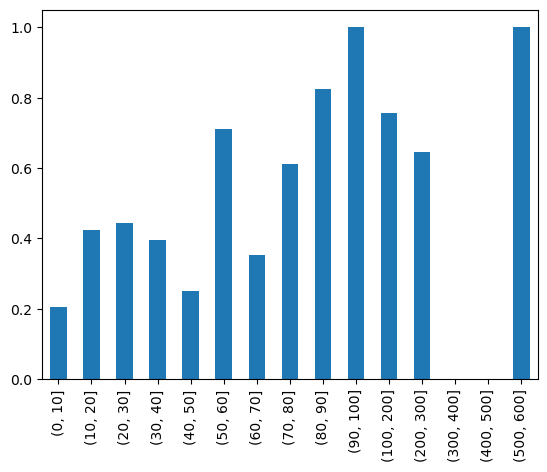

In [14]:
list_cut, prob = fare_range_plot(train)
train['Fare_level'] = pd.cut(x = train['Fare'], bins = list_cut, labels = prob, include_lowest = True, ordered = False)
test['Fare_level'] = pd.cut(x = test['Fare'], bins = list_cut, labels = prob, include_lowest = True, ordered = False)

In [15]:
train['Fare_level'] = train['Fare_level'].astype(float)
test['Fare_level'] = test['Fare_level'].astype(float)

## Cabin

<AxesSubplot:xlabel='RN', ylabel='Survived'>

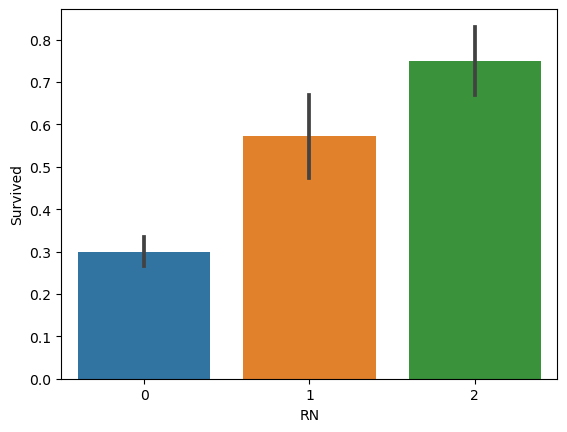

In [16]:
train['Cabin']=train['Cabin'].fillna('Z')
train['RN']=train['Cabin'].apply(lambda x:x[0])
def Cabin_Label(x):
    if ((x=='E')|(x=='D')|(x=='B')):
        return 2
    elif ((x=='C')|(x=='G')|(x=='A')|(x=='F')):
        return 1
    else:
        return 0
train['RN']=train['RN'].apply(Cabin_Label)
sns.barplot(x='RN',y='Survived',data=train)

In [17]:
test['Cabin']=test['Cabin'].fillna('Z')
test['RN']=test['Cabin'].  apply(lambda x:x[0])
def Cabin_Label(x):
    if ((x=='E')|(x=='D')|(x=='B')):
        return 2
    elif ((x=='C')|(x=='G')|(x=='A')|(x=='F')):
        return 1
    else:
        return 0
test['RN']=test['RN'].apply(Cabin_Label)
#sns.barplot(x='RN',y='Survived',data=test)

## Tickets


In [18]:
for dataset in Dataset:
    Ticket_Count = dataset['Ticket'].value_counts()
    dataset['peoplenumber'] = dataset['Ticket'].apply(lambda x:Ticket_Count[x])
#sns.barplot(x = 'peoplenumber', y = "Survived", data = all_data)

In [19]:
train.head(3)

,PassengerId,Survived,Pclass,Name,Sex,Age,Ticket,Fare,Cabin,Embarked,Title,relatives,Fare_level,RN,peoplenumber
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,A/5 21171,7.2500,Z,S,Mr,1,0.205607,0,1
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,PC 17599,71.2833,C85,C,Mrs,1,0.612903,1,1
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,STON/O2. 3101282,7.9250,Z,S,Miss,0,0.205607,0,1


## Drop feature

In [20]:
features_drop = ['PassengerId','Name','Ticket','Cabin','Embarked','Fare']
train = train.drop(features_drop, axis=1)
test = test.drop(features_drop, axis=1)
target = train['Survived']
train = train.drop('Survived', axis=1)

In [21]:
train.head(3)

,Pclass,Sex,Age,Title,relatives,Fare_level,RN,peoplenumber
0,3,male,22.0,Mr,1,0.205607,0,1
1,1,female,38.0,Mrs,1,0.612903,1,1
2,3,female,26.0,Miss,0,0.205607,0,1


In [22]:
# from sklearn.preprocessing import OneHotEncoder 
# from sklearn.impute import SimpleImputer 
# from sklearn.compose import ColumnTransformer 
# from sklearn.pipeline import Pipeline
# categorical_tf = Pipeline(steps = [ ("cat_impute", SimpleImputer(strategy = 'most_frequent')), ("encoder", OneHotEncoder()) ])

In [23]:
cat_feature = ['Sex','Title']
# col_tf = ColumnTransformer(transformers = [('cat', categorical_tf, cat_feature)])

In [24]:
from sklearn.preprocessing import LabelEncoder
l1=LabelEncoder()
for feature in cat_feature:
    train[feature]=l1.fit_transform(train[feature])
    test[feature]=l1.fit_transform(test[feature])

In [25]:
train.head(3)

,Pclass,Sex,Age,Title,relatives,Fare_level,RN,peoplenumber
0,3,1,22.0,2,1,0.205607,0,1
1,1,0,38.0,3,1,0.612903,1,1
2,3,0,26.0,1,0,0.205607,0,1


In [26]:
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.svm import SVC

import numpy as np

In [27]:
from sklearn.model_selection import KFold
from sklearn.model_selection import cross_val_score
k_fold = KFold(n_splits=10, shuffle=True, random_state=0)

In [28]:
from xgboost import XGBClassifier
xgb = XGBClassifier(learning_rate=0.01 ,n_estimators=860,max_depth=3,subsample=1, colsample_bytree=1, gamma=6,reg_alpha = 14,reg_lambda = 3)
scoring = 'accuracy'
score = cross_val_score(xgb, train, target, cv=k_fold, n_jobs=1, scoring=scoring)
print(score)
round(np.mean(score)*100,2)

[0.8        0.7752809  0.78651685 0.75280899 0.79775281 0.78651685
 0.78651685 0.78651685 0.79775281 0.79775281]


78.67